**Problem definition:**\
The Drop off ridesharing problem is researched. The problem is formulated into a mathematical model with decision variables, an objective functions and constrains. The Genetic Algorithm (GA) algorithm is implemented to solve this problem. An experiment with the real world data sets is done to test the performance of this algorithm. 
It is required to generate an optimal schedule for each dropoff to serve the passengers of Toronto in such a way that optimizes at least two of the following criteria, preferably all:

• Minimizing the total number of SAVs required.\
• Minimizing the total travel distance/time of SAVs’ trips.\
• Minimizing the total travel time of passengers’ trips.\
• Maximizing the number of matched (served) requests.\
• Minimizing the cost for the SAVs’ trips/loss during uncharged driving\
• Maximizing the SAV's earning/total profit.\
• Minimizing the cost for the passengers’ trips.\
• Minimizing passenger’s waiting time.\
• Balancing the routes of SAV load.\

In [1]:
import pandas as pd
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import osmnx as ox
from utilities import *

In [2]:
# You can use different excel data
#file_path = './data/Maven_stations_saved.csv'
file_path = './data/Dropoff_locations.csv'
df = pd.read_csv(file_path)
numberOfStops = len(df)
df

,Longitude,Latitude,Address
0,-79.389653,43.669624,Bay Station
1,-79.379568,43.768544,Bessarion Station
2,-79.368367,43.673658,Castle Frank Station
3,-79.418020,43.663659,Christie Station
4,-79.323692,43.683357,Coxwell Station
5,-79.346952,43.775110,Don Mills Station
6,-79.462910,43.750348,Downsview Station
7,-79.380984,43.656363,Dundas Station
8,-79.407034,43.674731,Dupont Station
9,-79.415660,43.780174,Finch Station


In [3]:
# store the values into a numpy array
addresses  = df.iloc[:, 2].values

In [4]:
POIS = []
for address in addresses:
    POIS.append(poi(address,"canada"))
POIS

[Name: Bay ID: 25991314,
 Name: Bessarion ID: 5318484724,
 Name: Castle Frank Station ID: 432581398,
 Name: Christie ID: 5262888213,
 Name: Coxwell Station ID: 7100591226,
 Name: Don Mills Station ID: 1246332677,
 Name: Sheppard West ID: 420561530,
 Name: Dundas ID: 249641649,
 Name: Dupont ID: 5320349317,
 Name: (Finch Station) ID: 582990836,
 Name: Eglinton West Station ID: 6592347255,
 Name: Kennedy Station ID: 5593394546,
 Name: Donlands ID: 55639063,
 Name: Kipling Station ID: 4597249809,
 Name: High Park Station ID: 2883464892,
 Name: Eglinton Station ID: 2266180445]

In [5]:
drawPOIS(POIS, zoom=10)

Map(center=[43.67628716875, -79.43114413142783], close_popup_on_click=False, controls=(ZoomControl(options=['p…

In [6]:
G = nx.DiGraph()
G.add_nodes_from(POIS)

In [7]:
# this will take 1-2 minutes because you need to find
# two routes between each pair of POIs
durations = []
for source in G.nodes():
    duration = []
    for destination in G.nodes():
        if source == destination: 
            duration.append(0)
            continue
        G.add_edge(source, destination, route = source.route_to(destination))
        route = source.route_to(destination)
        duration.append(route['duration'])
    durations.append(duration)

In [8]:
trip = np.array(durations)
trip

array([[   0. , 1243.5,  238.3,  306.9,  697.6, 1168.4, 1199.4, 3785.4,
         239.3, 1514.5,  730.3, 1339.4,  552.2, 1288.7,  765.1,  544.4],
       [1238. ,    0. ,  999.9, 1293.3, 1111.1,  281.2,  704.9, 4108.7,
        1250. ,  554.5,  747.6,  952.6, 1029. , 1624.1, 1310.6,  890.1],
       [ 238.1, 1095.4,    0. ,  501.8,  459.3,  930.1, 1363.6, 3820.4,
         404.9, 1521.9,  894.5, 1101.1,  313.9, 1323.7,  960. ,  664.3],
       [ 334.6, 1212.7,  529.7,    0. ,  989. , 1455.4, 1031.3, 3719.1,
         225.6, 1545.8,  562.2, 1630.8,  843.6, 1121.7,  497. ,  723. ],
       [ 697.4, 1076.6,  459.3,  961.1,    0. ,  911.3, 1575.1, 4029.4,
         864.2, 1503.1, 1223.3,  924.1,  170.8, 1532.7, 1282.9, 1049.5],
       [1241.8,  249.7, 1003.7, 1435.9, 1114.9,    0. ,  882.1, 4251.3,
        1392.6,  768. ,  890.2,  927.9, 1032.8, 1766.7, 1453.2, 1032.7],
       [1211.8,  692.1, 1378.5, 1063.1, 1615.8,  964.2,    0. , 3953.2,
        1019.8,  835.9,  517.4, 1457.3, 1533.7, 1468.6, 11

In [9]:
# define a function that can compute the fitness value of each solution in the population
def cal_pop_objective_1(m, pop):
    M = np.zeros([8,numberOfStops-1])
    fitness = np.zeros(8)
    for i in range(8):
        for j in range(numberOfStops-1):
            M[i,j] = m[pop[i,j]-1,pop[i,j+1]-1]
    for k in range(8):
        fitness[k] = np.sum(M[k])
    return fitness


In [10]:
# define a function that can select the best individuals in the current generation as the parents to produce the offsprings
def select_mating(pop, fitness, num_parents):
    parents = np.zeros([num_parents, pop.shape[1]])
    for parent_num in range(num_parents):
        min_fitness_index = np.where(fitness == np.min(fitness))
        min_fitness_index = min_fitness_index[0][0]
        parents[parent_num, :] = pop[min_fitness_index, :]
        fitness[min_fitness_index] = 999999999
    return parents


In [11]:
# implementation of order 1 crossover
def crossover(mum, dad):
    size = len(mum)

    # select random start/end position for crossover
    alice, bob = [-1] * size, [-1] * size
    start, end = sorted([random.randrange(size) for _ in range(2)])

    # replicate mum's sequence for alice
    alice_inherited = []
    for i in range(start, end + 1):
        alice[i] = mum[i]
        alice_inherited.append(mum[i])

    current_dad_position, current_mum_position = 0, 0

    fixed_pos = list(range(start, end + 1))
    i = 0
    while i < size:
        if i in fixed_pos:
            i += 1
            continue
        test_alice = alice[i]
        if test_alice==-1:
            dad_trait = dad[current_dad_position]
            while dad_trait in alice_inherited:
                dad_trait = dad[current_dad_position]
                current_dad_position += 1
            alice[i] = dad_trait
            alice_inherited.append(dad_trait)
        i += 1
    return alice


In [12]:
# implementation of swap mutation
def mutation(offspring_crossover):
    a = random.randint(0,numberOfStops-1)
    b = random.randint(0,numberOfStops-1)
    for i in range(offspring_crossover.shape[0]):
        mut_1 = offspring_crossover[i,a]
        mut_2 = offspring_crossover[i,b]
        offspring_crossover[i,a] = mut_2
        offspring_crossover[i,b] = mut_1
    return offspring_crossover


In [13]:
"implementation of genetic algorithm on SAV ride sharing problem"

# ga parameters
sol_per_pop = 8
num_parents_mating = 4
num_offsprings = 4

# define population size and offspring size
pop_size = (sol_per_pop, trip.shape[1])
offspring_size = (num_offsprings, trip.shape[1])

# generate the initial population
new_population = np.zeros(pop_size)
for i in range(8):
    new_population[i] = np.arange(1,numberOfStops+1)
    random.shuffle(new_population[i])
new_population = new_population.astype(int)

best_outputs = []
num_of_generation = 50000

running_time = np.zeros(num_of_generation)

for generation in range(num_of_generation):

    # record the starting time
    start_time = time.time()

    # compute the fitness of each individual in the population
    fitness = cal_pop_objective_1(trip, new_population)

    # record the best fitness in the current generation
    best_outputs.append(np.min(fitness))

    # select the best 4 individuals in the population as parents for mating
    parents = select_mating(new_population, fitness, num_parents_mating)

    # generate offsprings using crossover
    offspring_crossover = np.zeros(offspring_size)
    r_1 = np.random.random()
    if r_1 < 0.7: # crossover probability = 0.7
        offspring_crossover[0] = crossover(parents[0], parents[1])
        offspring_crossover[1] = crossover(parents[1], parents[0])
        offspring_crossover[2] = crossover(parents[2], parents[3])
        offspring_crossover[3] = crossover(parents[3], parents[2])
    else:
        offspring_crossover[0] = parents[0]
        offspring_crossover[1] = parents[1]
        offspring_crossover[2] = parents[2]
        offspring_crossover[3] = parents[3]

    # offsprings mutation
    r_2 = np.random.random()
    if r_2 < 0.05: # mutation probability = 0.05
        offspring_mutation = mutation(offspring_crossover)
    else:
        offspring_mutation = offspring_crossover

    # generate the new population based on parents and offsprings
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # compute and store the running time
    running_time[generation] = time.time() - start_time


In [14]:
# get the best solution after iterating all the generations
# compute the fitness of each individual in the final generation
fitness = cal_pop_objective_1(trip, new_population)
# return the index of the solution corresponding to the best fitness
best_index = np.where(fitness == np.min(fitness))

running_time = running_time.cumsum()

# to get the index of iteration when the fitness reaches its minimum value (convergence point of the algorithm)
convergence_index = np.where(best_outputs == np.min(best_outputs))
convergence_time = running_time[convergence_index]

print("Best solution:", new_population[best_index, :])
print("Best fitness:", fitness[best_index])
print("The algorithm converges in", np.min(convergence_index), "iterations.")
print("The algorithm converges in", np.min(convergence_time), "seconds.")


Best solution: [[[ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]
  [ 8 14 15 16 11  7 10  2  6  1  4  9  3 13  5 12]]]
Best fitness: [10811. 10811. 10811. 10811. 10811. 10811. 10811. 10811.]
The algorithm converges in 10747 iterations.
The algorithm converges in 3.04986834526062 seconds.


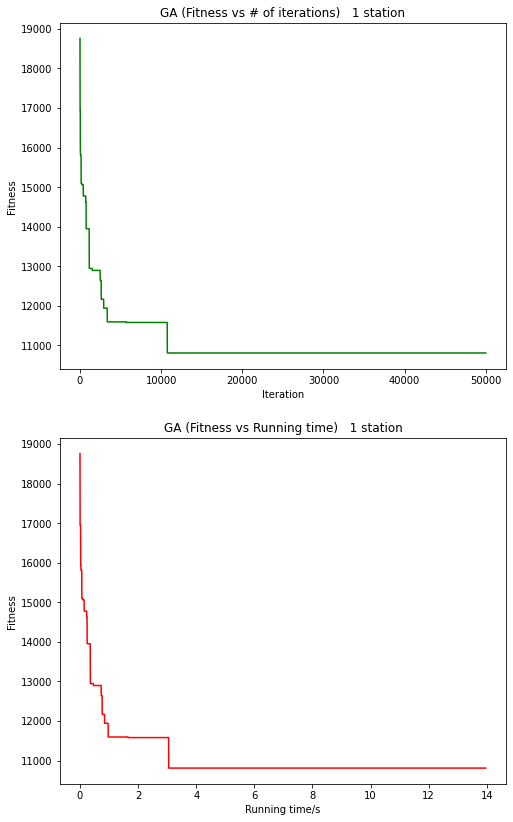

In [15]:
fig, ax = plt.subplots(2, figsize = (8,numberOfStops-2))
ax[0].plot(best_outputs, 'green')
ax[0].set_xlabel("Iteration", fontsize = 10)
ax[0].set_ylabel("Fitness", fontsize = 10)
ax[0].set_title("GA (Fitness vs # of iterations)   1 station", fontsize = 12)

ax[1].plot(running_time, best_outputs, 'red')
ax[1].set_xlabel("Running time/s", fontsize = 10)
ax[1].set_ylabel("Fitness", fontsize = 10)
ax[1].set_title("GA (Fitness vs Running time)   1 station", fontsize = 12)
plt.show()

In [16]:
#Visualization
optimalRoute = new_population[best_index, :]
optimalRoute = optimalRoute[0][0]
optimalRoute[0]
currentRoute = G[POIS[optimalRoute[0]]][POIS[optimalRoute[1]]]['route']['coords']
for i in range(1,len(optimalRoute)-1):
    currentRoute += G[POIS[optimalRoute[i]-1]][POIS[optimalRoute[i+1]-1]]['route']['coords']
drawRoute(currentRoute)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Map(center=[43.769137, -79.376669], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…